# Memes LDA topics, cosine similarity, common tags

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import numpy as np
import scipy.sparse
import json
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
memes_data = []
filename = '/Users/rabauti/repos/deng_g7/pipeline_1/dags/data/kym_unique_filter_1.json'
with open(filename,'r') as f:
    memes_dict = json.load(f)
    f.close()
tags_dict = {}

for (id, meme) in memes_dict.items():
    convertedTags = []
    for tag in meme['_tags']:
        if not tag in tags_dict:
            tags_dict[tag] = len(tags_dict)
        convertedTags.append(str(tags_dict[tag]))
    memes_data.append((meme['Id'], meme['meta_description'],' '.join(convertedTags)))

df = pd.DataFrame(memes_data, columns=['Id', 'desc', 'tag'])

In [3]:
#replace None with ""
df.fillna("",inplace=True)
df.head()

,Id,desc,tag
0,--15,[working in progress] 淡定 is a phrase used to d...,0 1 2
1,0-interest,0% Interest is an image macro banner used as a...,3
2,009-sound-system-background-songs,009 Sound System Background Songs are tracks b...,4 5 6 7 8 9 10 11 12 13 14 15
3,05x-a-presses-but-first-we-need-to-talk-about-...,“SM64 – Watch for Rolling Rocks – 0.5x A Press...,16 17 18 19 20 21 22 23 24 25 26 27
4,09-f9-11-02-9d-74-e3-5b-d8-41-56-c5-63-56-88-c0,09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C...,28 29 30 31


## Extract LDA topics

Source 1
https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/
    
Source 2 
https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn
 

In [4]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse
import time
import json
import argparse

#preprocessing
import nltk

In [5]:
#stopwords
from nltk.corpus import stopwords
# tokenizing
from nltk import word_tokenize
#from nltk.tokenize import sent_tokenize, pos_tag_sents, pos_tag
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer


In [6]:
TOPICS = 10
KEYWORDS = 10

In [7]:

#def clean_text_lemmatization(text):
#    """
#        splits to sentences and tokens, lemmatizes
#        removes
#            * stopwords [default stopwords + topic specific words]
#            * words shorther than 4 chars
#        returns cleaned lemmatized text
#    """
#    global stop_words
#    wnl = WordNetLemmatizer()
#    tagged_text = pos_tag_sents(map(word_tokenize, [text]))
#    tagged_words = []
#    for sent in tagged_text:
#        for w  in sent:
#            tagged_words.append(w)
#
#    tokens =[wnl.lemmatize(word,pos[0].lower()) if pos[0].lower() in ['a','n','v'] else wnl.lemmatize(word) for word,pos in tagged_words]
#    tokens = [t for t in tokens if t not in stop_words and len(t)>3]
#    return " ".join(tokens)


def clean_text_simple(text):
    """
        splits to sentences and tokens, without lemmatization
        removes
            * stopwords
            * words shorther than 4 chars
        returns cleaned text
    """
    wnl = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    tokens = [wnl.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
    return " ".join(tokens)

In [8]:
# Field specific stopwords were extracted from (filtered) memes content texts.
# 200 most frequent words were taken.

custom_stopwords = ['post', 'show', 'user', 'video', 'use', 'feature', 'first', 'image', 'one', 'title', 'like', 'series', 'also', 'day', 'upload', '000', 'meme', '10', 'reddit', 'make', 'youtube', 'gain', 'character', 'create', 'site', 'include', 'year', 'right', '11', 'original', 'know', 'several', 'view', 'begin', 'online', 'may', 'leave', 'become', 'popular', 'page', 'submit', 'internet', 'time', 'comment', 'two', 'many', '12', 'search', 'receive', 'tumblr', 'twitter', 'appear', '2012',     'blog', 'people', '2011', 'game', 'new', 'april', 'within', 'october', 'march', 'july', 'january', 'august', 'november', 'various', 'since', 'june', 'following', 'publish', 'facebook', '13', 'february', 'take', 'thread', 'month', 'september', 'say', '2010', 'parody', 'december', 'often', 'phrase', 'name', 'wikipedia', '2013', 'release', 'well', 'news', 'version', 'subreddit', 'later', 'get', 'youtuber', 'go', 'article', 'redditor', 'see', '14', '2014', 'picture', 'find', 'caption', 'next', 'earliest', 'example', 'macro', '2009', 'com', 'song', 'fan', 'call', 'launch', '2015', 'another', '15', '2008', '4chan', 'come', 'note', 'result', 'million', 'share', 'man', 'similar', 'tweet', 'follow', 'photo', '2016', 'early', 'archive', 'point', 'play', 'start', 'website', 'would', 'spread', 'board', '16', '2007', 'photograph', 'base', 'forum', 'film', 'three', 'refers', 'ask', 'episode', 'urban', 'via', 'scene', 'joke', 'dictionary', 'music', 'daily', 'around', 'reference', 'give', 'week', 'hour', '17', 'tv', 'community', 'popularity', 'reaction', 'clip', 'look', 'vote', 'world', 'due', '2006', '24', 'face', 'word', '20', 'garner', 'buzzfeed', '2017', 'way', 'write', '18', 'best', 'medium', 'upwards', 'term', 'viral', 'single', 'channel', 'instance', 'back', 'star', '1st', 'list', '100', 'inspire', 'among', 'group', 'however', 'american',
'end', 'tag', 'account', 'web', 'response', '6th', 'cover', 'funny', 'available', '4th', '5th', 'machine', 'story', '3rd', 'late', 'comic', '27th', 'member', '2nd', 'even', 'part', '7th', 'refer', 'japanese', 'air', '11th', '20th', '9th', 'number', '10th', '19', 'subject', 'quote', '8th', 'describe', 'art', 'notable', '17th', 'entry', '13th', 'social', 'life', '12th', 'known', 'prior', 'lead', 'different', '14th', '15th', '19th', 'television', '21st', 'woman', 'originally', 'place', 'something', '18th', 'along', 'variation', 'expression', 'second', '23rd', 'style', '28th', '16th', '25th', 'culture', 'humor', 'four', 'photoshopped', 'according', '24th', 'highlight', 'person', 'typically', 'official', '500', 'gather', 'continue', '22nd', 'throughout', 'topic', 'still', 'top', '200', '26th', 'hold', 'retweets', 'wayback', 'anime', 'mock', 'line', '30th', 'report', 'associate', '21', 'others', 'wiki', '29th', 'thing', '2005', 'need', 'movie', 'someone', 'accumulate', 'upvoted', 'work', 'add', 'claim', 'message', 'animated', 'guy', 'pop', 'much', '300', 'text', 'remix', 'link', 'contain', 'quickly', 'catchphrase', 'could', 'depict', '400', 'english', 'google', 'player', 'discussion', 'girl', 'results', 'le', 'deviantart', 'trend', 'form', 'compilation', 'question', 'section', '22', 'origin', 'little', 'soon', 'funnyjunk', 'mean', 'forums', 'friend', 'read', '2004', 'reach', 'real', 'set', 'artist', 'though', '23', 'live', 'edit', '600', 'wear', 'mention', 'reply', 'usually', 'love', 'exploitable', 'five', 'think', 'tell', 'date', 'hashtag', 'hit', 'attempt', 'remixes', 'animal', 'poster', 'memes', 'spawn', 'originate', 'child', 'famous', '25', 'black', 'short', 'footage', '800', 'watch', 'appearance', 'accompany', 'interview', 'try', 'old', 'run', 'front', 'instagram', 'head', 'involve', 'favorite', 'talk', 'ever', 'photoshop', '700', '30', 'explain']

#default stopwords + custom_stopwords
stop_words=set(stopwords.words('english'))
[stop_words.add(w) for w in custom_stopwords]
''


''

In [9]:
# clean and lemmatize text
#df['cleaned_desc']=df['desc'].apply(clean_text_lemmatization)
# temporary use simple version
df['cleaned_desc'] = df['desc'].apply(clean_text_simple)

In [10]:
# EXTRACTING THE FEATURES AND CREATING THE DOCUMENT-TERM-MATRIX ( DTM ) In DTM the values are the TFidf values.

vect = TfidfVectorizer(stop_words=stop_words,max_features=1000)
vect_text = vect.fit_transform(df['cleaned_desc'])


In [11]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=TOPICS,learning_method='online',random_state=42,max_iter=20)
lda_top = lda_model.fit_transform(vect_text)
vocab = vect.get_feature_names()


In [12]:
#   collectiong data
# add Unknown topic for topics where is hard to decide in which topic it belongs
extracted_topics = [(-1, 'Unknown')]
extracted_topic_keywords = []

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    extracted_topics.append( (i+1, f'Topic {i+1}'))
    for w in sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:KEYWORDS]:
        extracted_topic_keywords.append((i+1, w[1], w[0],))
        


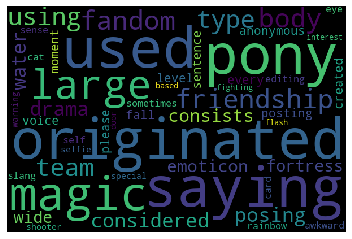

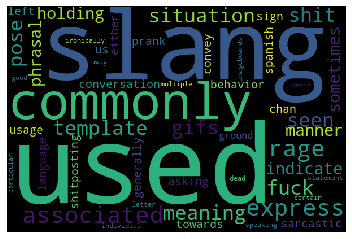

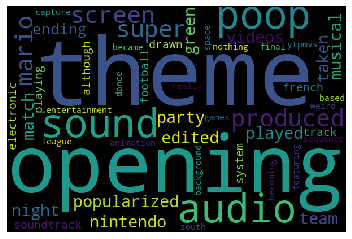

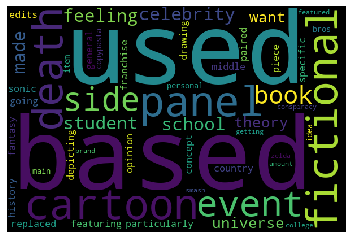

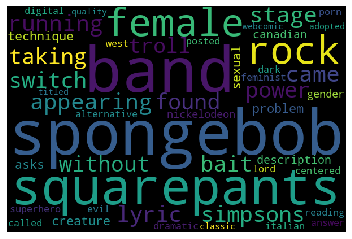

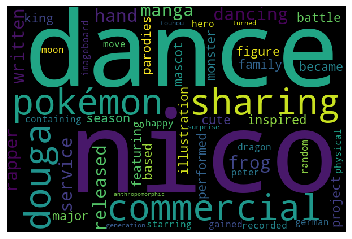

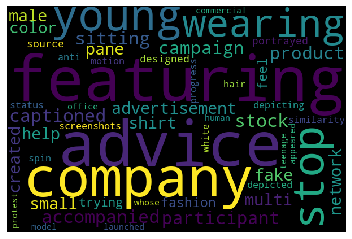

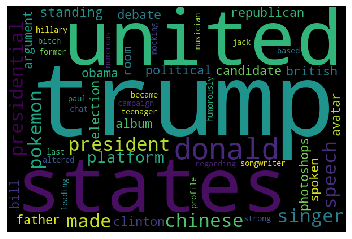

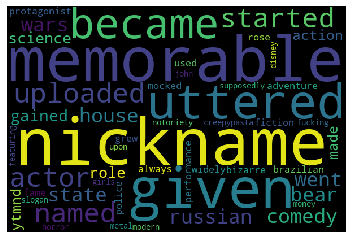

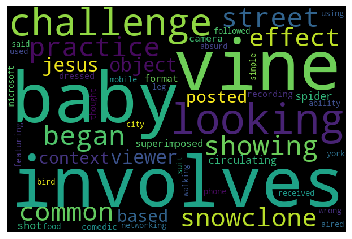

In [13]:
#import sys
#!conda install --yes --prefix {sys.prefix}  -c conda-forge wordcloud
from wordcloud import WordCloud

# Generate a word cloud image for given topic
def draw_word_cloud(index):
    imp_words_topic=""
    comp=lda_model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]
    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    for i in range(TOPICS):
    draw_word_cloud(i)


In [14]:
df['topic'] = ''
df['topic_score'] = ''
for j in range(df['Id'].shape[0]):
    ([topic]) = np.where(lda_top[j] == max(lda_top[j]))
    if len(topic) > 1:
        topicId = 0
        topicProbScore = 0.0
    else:
        topic = topic[0]
        topicId = topic + 1
        topicProbScore = lda_top[j][topic]
    df['topic'][j] = str(topicId)
    df['topic_score'][j] = round(topicProbScore,2)
    #memeTopics.append( (df['Id'][j], topicId, topicProbScore ) )


In [15]:
df.head()

,Id,desc,tag,cleaned_desc,topic,topic_score
0,--15,[working in progress] 淡定 is a phrase used to d...,0 1 2,working progress used calmness associated emot...,2,0.34
1,0-interest,0% Interest is an image macro banner used as a...,3,Interest banner used interesting request Origi...,1,0.69
2,009-sound-system-background-songs,009 Sound System Background Songs are tracks b...,4 5 6 7 8 9 10 11 12 13 14 15,Sound System Background Songs track project So...,3,0.6
3,05x-a-presses-but-first-we-need-to-talk-about-...,“SM64 – Watch for Rolling Rocks – 0.5x A Press...,16 17 18 19 20 21 22 23 24 25 26 27,SM64 Watch Rolling Rocks 0.5x Presses uploaded...,9,0.55
4,09-f9-11-02-9d-74-e3-5b-d8-41-56-c5-63-56-88-c0,09 F9 11 02 9D 74 E3 5B D8 41 56 C5 63 56 88 C...,28 29 30 31,block code written hexadecimal discovered decr...,1,0.4


## Cosine similarity of descriptions

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1. 
...


https://en.wikipedia.org/wiki/Cosine_similarity

One advantage of cosine similarity is its **low-complexity**, especially for sparse vectors: only the non-zero dimensions need to be considered.

In [16]:
# https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents

In [17]:
def calculate_cosine_similarity(corpus):
    vect = TfidfVectorizer(min_df=1, stop_words="english")
    tfidf = vect.fit_transform(corpus)

    #https://docs.scipy.org/doc/scipy/reference/sparse.html
    pairwise_similarity = tfidf * tfidf.T

    #set similary of compraring with self to -1
    n, _ = pairwise_similarity.shape
    pairwise_similarity[np.arange(n), np.arange(n)] = -1.0

    return (pairwise_similarity)

In [18]:
#order by LDA topic
df = df.sort_values('topic')

In [19]:
print (f"Total memes to compare: {df.shape[0]}")

'Total memes to compare: 8174'

In [20]:
n = df.shape[0]

In [21]:
pairwise_desc_similarity = calculate_cosine_similarity(df['desc'][:n])
pairwise_desc_similarity.data=np.round(pairwise_desc_similarity.data,2)
cx = scipy.sparse.coo_matrix(pairwise_desc_similarity)
cx

<8174x8174 sparse matrix of type '<class 'numpy.float64'>'
	with 24771396 stored elements in COOrdinate format>

In [22]:
pairwise_desc_similarity_array = scipy.sparse.lil_matrix(pairwise_desc_similarity).toarray()

**Visualizing result**



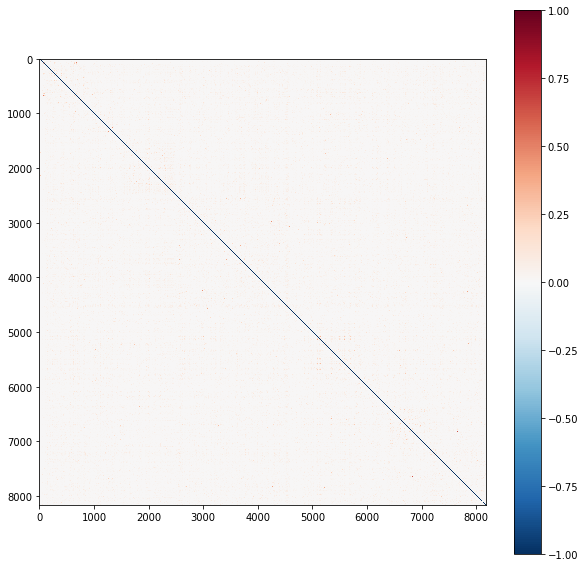

In [23]:
#import sys
#!conda install --yes --prefix {sys.prefix}  -c conda-forge mlxtend

from mlxtend.plotting import heatmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

heatmap(pairwise_desc_similarity_array, figsize=(10, 10), cell_values=False, cmap='RdBu_r')
plt.show()

**Transform to pandas dataframe**

In [24]:

cx = scipy.sparse.coo_matrix(pairwise_desc_similarity_array)
result_table = {'meme1':[], 'meme2':[], 'score':[]}
for i,j,v in zip(cx.row, cx.col, cx.data):
    result_table['meme1'].append(df['Id'][i])
    result_table['meme2'].append(df['Id'][j])
    result_table['score'].append(v)
dfScores = pd.DataFrame.from_dict(result_table) 

In [25]:
dfScores.sort_values('score', ascending = False).head(10)

,meme1,meme2,score
1586296,bernie-dance,asiacopter,1.0
19469616,the-revenant-bear-rape-rumor,spoons-rattling,1.0
972799,asiacopter,asa7be,1.0
972847,asiacopter,badass-rory,1.0
972899,asiacopter,bernie-dance,1.0
1586254,bernie-dance,angry-dog-noises,1.0
668282,angry-dog-noises,bernie-dance,1.0
1586290,bernie-dance,asa7be,1.0
668230,angry-dog-noises,badass-rory,1.0
1586338,bernie-dance,badass-rory,1.0


# Common tags

In [26]:
def common_words(corpus):
    vect = CountVectorizer()
    tfidf = vect.fit_transform(corpus)
    pairwise_similarity = tfidf * tfidf.T

    #set similary of compraring with self to -1
    n, _ = pairwise_similarity.shape
    pairwise_similarity[np.arange(n), np.arange(n)] = -1.0
    return (pairwise_similarity)

In [27]:
pairwise_common_tags = common_words(df['tag'])

In [28]:
pairwise_common_tags_array = scipy.sparse.lil_matrix(pairwise_common_tags).toarray()

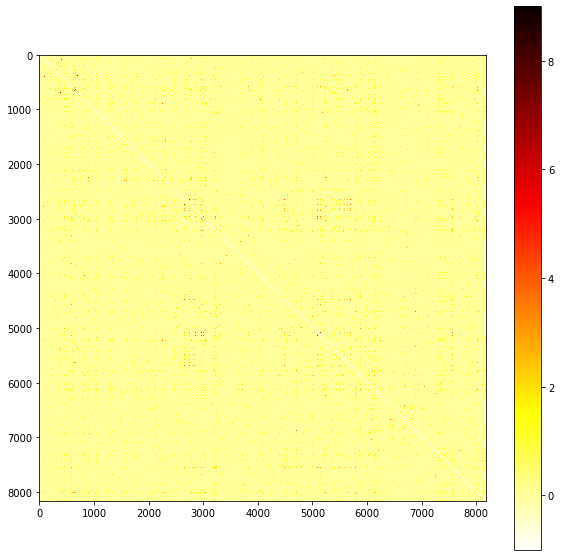

In [29]:
from mlxtend.plotting import heatmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

heatmap(pairwise_common_tags_array, figsize=(10, 10), cell_values=False, cmap='hot_r')
plt.show()

In [30]:
cx = scipy.sparse.coo_matrix(pairwise_common_tags)
result_table = {'meme1':[], 'meme2':[], 'score':[]}
for i,j,v in zip(cx.row, cx.col, cx.data):
    result_table['meme1'].append(df['Id'][i])
    result_table['meme2'].append(df['Id'][j])
    result_table['score'].append(v)
dfScores = pd.DataFrame.from_dict(result_table) 

In [31]:
dfScores.sort_values('score', ascending = False).head(10)

,meme1,meme2,score
937291,gran-turismo-high-speed-glitches,good-heavens-just-look-at-the-time,9
1940246,powerball-jackpot-redistribution-math,how-to-wear-a-mens-shirt,9
1091373,how-to-wear-a-mens-shirt,powerball-jackpot-redistribution-math,9
2513034,the-pest-pestposting,you-just-have-to-say-that-youre-fine,9
916997,good-heavens-just-look-at-the-time,gran-turismo-high-speed-glitches,9
2867846,you-just-have-to-say-that-youre-fine,the-pest-pestposting,9
7352,200-mad,lip-dub,8
977355,hamood-habibi,hijabi-problems,8
943898,greek-grandpa-troll-markos-leronymakis,gronked,8
994436,haters-to-the-left,hijabi-problems,8
